In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Daten laden
file_path = 'vibration_messung_2025-10-15_1704-1737.csv'
df = pd.read_csv(file_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print("Daten geladen:")
print(df.head())

Daten geladen:
                                    sensor_id  wert
time                                               
2025-10-15 17:04:00.004000+02:00  AnalogValue    67
2025-10-15 17:04:00.024000+02:00  AnalogValue     0
2025-10-15 17:04:00.034000+02:00  AnalogValue     0
2025-10-15 17:04:00.044000+02:00  AnalogValue     0
2025-10-15 17:04:00.054000+02:00  AnalogValue     0


## Feature Engineering

Rohdaten sind oft verrauscht. Wir wenden verschiedene Techniken an, um nützliche Informationen zu extrahieren:

1.  **Rolling Statistics**: Wir berechnen Mittelwert, Standardabweichung, Min und Max über ein Zeitfenster (Glättung).
2.  **Lag Features**: Wir verwenden Werte aus vorherigen Zeitschritten (z. B. t-1), da die Vergangenheit oft die Zukunft beeinflusst.
3.  **Rate of Change**: Wir berechnen die Differenz zwischen aufeinanderfolgenden Werten, um Trends zu erfassen.

Zusätzlich erstellen wir ein **Label** für das überwachte Lernen: Wenn der Mittelwert über 1000 liegt, klassifizieren wir dies als 'Hohe Vibration' (1), andernfalls als 'Normal' (0).

In [2]:
# Berechne rollierende Statistiken (Fenstergröße 50)
window_size = 50
df_features = df[['wert']].rolling(window=window_size).agg(['mean', 'std', 'min', 'max']).dropna()
df_features.columns = df_features.columns.droplevel(0)

# --- NEU: Zusätzliche Features ---
# 1. Lag Features (Werte aus dem vorherigen Schritt)
df_features['mean_lag1'] = df_features['mean'].shift(1)
df_features['std_lag1'] = df_features['std'].shift(1)

# 2. Änderungsrate (Differenz zum vorherigen Schritt)
df_features['mean_change'] = df_features['mean'].diff()



# Entferne NaNs, die durch shift/diff entstanden sind
df_features.dropna(inplace=True)
# --------------------------------

# Erstelle Ziel-Label: "Hohe" Vibration (> 1000) vs "Normal"
# Wir verwenden den Mittelwert des Fensters für das Label
threshold = 1000
df_features['label'] = (df_features['mean'] > threshold).astype(int)

print("Features und Labels:")
print(df_features.head())
print(f"Verteilung der Labels:\n{df_features['label'].value_counts()}")

# --- VISUALISIERUNG ---
# 1. Rollierende Statistiken vs. Rohdaten (Erste 1000 Punkte zur Übersichtlichkeit)
plt.figure(figsize=(15, 5))
plt.plot(df['wert'].iloc[:1000], label='Rohdaten', alpha=0.5)
plt.plot(df_features['mean'].iloc[:1000], label='Rollierender Mittelwert (Fenster 50)', linewidth=2)
plt.title('1. Rollierende Statistiken: Glättung der Daten')
plt.legend()
plt.show()

# 2. Lag Features (Autokorrelation)
plt.figure(figsize=(6, 6))
plt.scatter(df_features['mean'], df_features['mean_lag1'], alpha=0.1, s=1)
plt.title('2. Lag Features: Aktueller Mittelwert vs. Vorheriger Mittelwert')
plt.xlabel('Mittelwert (t)')
plt.ylabel('Mittelwert (t-1)')
plt.show()

# 3. Änderungsrate
plt.figure(figsize=(15, 5))
plt.plot(df_features['mean_change'].iloc[:1000])
plt.title('3. Änderungsrate: Stabilität des Signals')
plt.ylabel('Änderung im Mittelwert')
plt.show()

Features und Labels:
                                   mean        std  min    max  mean_lag1  \
time                                                                        
2025-10-15 17:04:00.554000+02:00  44.26  58.683450  0.0  210.0      45.60   
2025-10-15 17:04:00.574000+02:00  44.28  58.668227  0.0  210.0      44.26   
2025-10-15 17:04:00.584000+02:00  45.80  58.481813  0.0  210.0      44.28   
2025-10-15 17:04:00.594000+02:00  45.80  58.481813  0.0  210.0      45.80   
2025-10-15 17:04:00.604000+02:00  47.30  58.244471  0.0  210.0      45.80   

                                   std_lag1  mean_change  label  
time                                                             
2025-10-15 17:04:00.554000+02:00  58.416520        -1.34      0  
2025-10-15 17:04:00.574000+02:00  58.683450         0.02      0  
2025-10-15 17:04:00.584000+02:00  58.668227         1.52      0  
2025-10-15 17:04:00.594000+02:00  58.481813         0.00      0  
2025-10-15 17:04:00.604000+02:00  58.481813

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Supervised Learning: Klassifikation

Hier trainieren wir Modelle, um zu entscheiden, ob ein Zustand kritisch ist oder nicht.
Wir vergleichen verschiedene Algorithmen:
*   **Decision Tree (Entscheidungsbaum)**: Ein einfaches, interpretierbares Modell, das Daten basierend auf Feature-Werten aufteilt.
*   **Random Forest**: Ein Ensemble aus vielen Entscheidungsbäumen. Sehr robust.
*   **Support Vector Machine (SVM)**: Versucht, eine optimale Grenze zwischen Klassen zu finden.
*   **K-Nearest Neighbors (KNN)**: Klassifiziert basierend auf Ähnlichkeit zu Nachbarn.
*   **Gradient Boosting**: Baut Bäume sequenziell auf, um Fehler der vorherigen zu korrigieren.

In [3]:
# Bibliotheken importieren
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Daten vorbereiten
X = df_features[['mean', 'std', 'min', 'max', 'mean_lag1', 'std_lag1', 'mean_change']]
y = df_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Dictionary zum Speichern der Ergebnisse für späteren Vergleich
results = {}

# --- 1. Decision Tree (Beispiel) ---
print("Trainiere Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
results['Decision Tree'] = acc_dt
print(f"Decision Tree Genauigkeit: {acc_dt:.4f}")

# --- 2. Random Forest (Beispiel) ---
print("\nTrainiere Random Forest...")
rf_model = RandomForestClassifier(n_estimators=2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
results['Random Forest'] = acc_rf
print(f"Random Forest Genauigkeit: {acc_rf:.4f}")

# --- 3. Support Vector Machine (TODO) ---
# TODO: Initialisiere SVC, trainiere das Modell, mache Vorhersagen und berechne die Genauigkeit
print("\nTrainiere SVM (TODO)...")
# svm_model = ...
# svm_model.fit(...)
# y_pred_svm = ...
# acc_svm = ...
# results['SVM'] = acc_svm
# print(f"SVM Genauigkeit: {acc_svm:.4f}")

# --- 4. K-Nearest Neighbors (TODO) ---
# TODO: Initialisiere KNeighborsClassifier, trainiere, mache Vorhersagen und berechne die Genauigkeit
print("\nTrainiere KNN (TODO)...")
# knn_model = ...
# ...

# --- 5. Gradient Boosting (TODO) ---
# TODO: Initialisiere GradientBoostingClassifier, trainiere, mache Vorhersagen und berechne die Genauigkeit
print("\nTrainiere Gradient Boosting (TODO)...")
# gb_model = ...
# ...

# --- Vergleich ---
if results:
    plt.figure(figsize=(10, 5))
    plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.title('Vergleich der Klassifikationsmodelle')
    plt.ylabel('Genauigkeit')
    plt.ylim(0, 1.1)
    plt.show()
else:
    print("Noch keine Modelle trainiert.")

Trainiere Decision Tree...
Decision Tree Genauigkeit: 1.0000

Trainiere Random Forest...
Random Forest Genauigkeit: 0.9996

Trainiere SVM (TODO)...

Trainiere KNN (TODO)...

Trainiere Gradient Boosting (TODO)...


<IPython.core.display.Javascript object>

## Supervised Learning: Regression

Bei der Regression wollen wir keinen Zustand (Klasse) vorhersagen, sondern einen **konkreten numerischen Wert**.
Aufgabe: Wir versuchen, den **Mittelwert** basierend auf den anderen Features ('std', 'min', 'max') vorherzusagen.

Modelle:
*   **Linear Regression**: Sucht nach einem linearen Zusammenhang.
*   **Decision Tree Regressor**: Ein Entscheidungsbaum für numerische Werte.
*   **Random Forest Regressor**: Ein Ensemble von Entscheidungsbäumen für kontinuierliche Werte.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Daten zuerst bereinigen
cols = ['std', 'min', 'max', 'mean', 'mean_lag1', 'std_lag1', 'mean_change']
df_clean = df_features[cols].replace([np.inf, -np.inf], np.nan).dropna()

X_reg = df_clean[['std', 'min', 'max', 'mean_lag1', 'std_lag1', 'mean_change']]
y_reg = df_clean['mean']

# 2. Aufteilen
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
)

print(f"Starte Training mit {len(X_train_r)} Beispielen...")

# --- 1. Decision Tree Regressor (Beispiel) ---
print("\nTrainiere Decision Tree Regressor...")
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_reg.fit(X_train_r, y_train_r)
y_pred_dt = dt_reg.predict(X_test_r)

mse_dt = mean_squared_error(y_test_r, y_pred_dt)
r2_dt = r2_score(y_test_r, y_pred_dt)
print(f"Decision Tree - MSE: {mse_dt:.2f}, R2: {r2_dt:.4f}")

# --- 2. Linear Regression (TODO) ---
# TODO: Initialisiere LinearRegression, trainiere, mache Vorhersagen und berechne MSE/R2
print("\nTrainiere Linear Regression (TODO)...")
# lr_model = ...
# ...
# print(f"Linear Regression - MSE: {mse_lr:.2f}, R2: {r2_lr:.4f}")

# --- 3. Random Forest Regressor (TODO) ---
# TODO: Initialisiere RandomForestRegressor, trainiere, mache Vorhersagen und berechne MSE/R2
print("\nTrainiere Random Forest Regressor (TODO)...")
# rf_reg = ...
# ...
# print(f"Random Forest - MSE: {mse_rf:.2f}, R2: {r2_rf:.4f}")

Starte Training mit 128652 Beispielen...

Trainiere Decision Tree Regressor...
Decision Tree - MSE: 3.97, R2: 0.9999

Trainiere Linear Regression (TODO)...

Trainiere Random Forest Regressor (TODO)...


## Unsupervised Learning: K-Means Clustering

Hier haben wir keine Labels. Der Algorithmus versucht selbstständig, Gruppen (Cluster) in den Daten zu finden.

In [5]:
# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainiere K-Means (wir erwarten 2 Cluster: Normal und Hoch)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.scatter(df_features.index, df_features['mean'], c=clusters, cmap='viridis', marker='.')
plt.title('K-Means Clustering der Vibrationsdaten')
plt.xlabel('Zeit')
plt.ylabel('Mittlere Vibration')
plt.show()

<IPython.core.display.Javascript object>

# Reinforcement Learning Showcase

In diesem Abschnitt untersuchen wir, wie sich Reinforcement Learning (RL) auf ein einfaches, aber klassisches Problem anwenden lässt: das Spielen von Tic-Tac-Toe. Tic-Tac-Toe eignet sich hervorragend als Experimentierfeld für RL-Methoden, da das Spiel überschaubar komplex ist, klare Regeln besitzt und jede Aktion direkte Konsequenzen auf den weiteren Spielverlauf hat. Gleichzeitig entsteht bereits in diesem kleinen Umfeld ein spannender Lernprozess: Ein Agent muss durch Ausprobieren herausfinden, welche Züge langfristig zu einem Sieg führen und welche Situationen vermieden werden sollten.

Indem wir mehrere selbstspielende Agenten gegeneinander antreten lassen und ihre Strategien über Generationen hinweg weiterentwickeln, können wir beobachten, wie aus zufälligem Verhalten allmählich zielgerichtete Spielzüge entstehen – ganz ohne explizit programmierte Spielstrategie.

## Spiellogik und Board-Darstellung

In dieser Zelle definieren wir die grundlegenden Bausteine, die für jede spätere Lern- oder Visualisierungslogik notwendig sind. Zunächst legen wir mit der GameState-Enum drei mögliche Spielzustände fest: Das Spiel läuft noch, ein Spieler hat gewonnen oder die Partie endet unentschieden.

Die Klasse Board repräsentiert anschließend ein Tic-Tac-Toe-Spielfeld. Sie speichert intern eine 3×3-Matrix, in der die aktuellen Spielzüge ('X' oder 'O') abgelegt werden. Zusätzlich kann das Board optional eine Matplotlib-Achse (ax) erhalten, um den aktuellen Zustand des Spielfelds grafisch darzustellen. Das erlaubt uns, Spiele sowohl rein logisch im Hintergrund ablaufen zu lassen als auch visuell nachzuvollziehen.

Die Methode draw_board() zeichnet bei Bedarf das Gitter und die gesetzten Symbole. Die Methoden check_if_occupied() und place() validieren Züge und aktualisieren das Spielfeld. Gleichzeitig prüft place(), ob der aktuelle Zug zu einem Sieg oder einem Unentschieden geführt hat und gibt den entsprechenden GameState zurück. Damit bildet diese Klasse das zentrale Fundament für die gesamte Interaktion zwischen den späteren lernenden Agenten und der Spielumgebung.

In [ ]:
from enum import Enum

class GameState(Enum):
    OPEN = 0    # Game is still ongoing
    WIN = 1     # A player has won
    DRAW = 2    # Game ended in a draw

class Board:


    def __init__(self, ax: Axes | None):
        self.positions = [['', '', ''],
                          ['', '', ''],
                          ['', '', '']]
        
        self.ax = ax


    def draw_board(self):
        if self.ax is not None:
            with plt.xkcd():

                cl= [156,8,24]
                cl = [i/255 for i in cl]

                self.ax.axis('off') 
                

                hor_1 = [1,1,1,1]
                hor_2 = [2,2,2,2]

                ver_1_x = [1,1,1,1]
                ver_1_y = [0,1,2,3]

                ver_2_x = [2,2,2,2]
                ver_2_y = [0,1,2,3]

                self.ax.plot(hor_1, color = cl, lw = 3)
                self.ax.plot(hor_2, color = cl, lw = 3)
                self.ax.plot(ver_1_x, ver_1_y, color = cl, lw = 3)
                self.ax.plot(ver_2_x, ver_2_y, color = cl, lw = 3)

            
                for row in range(3):
                    for col in range(3):
                        x, y = col + 0.5, 2 - row + 0.5  
                        symbol = self.positions[row][col]
                        if symbol == 'X':
                            self.ax.text(x, y, 'X', fontsize=48, ha='center', va='center', color=cl)
                        elif symbol == 'O':
                            self.ax.text(x, y, 'O', fontsize=48, ha='center', va='center', color=cl)
    

    def check_if_occupied(self, pos):
        if not -1 < pos[0] < 3:
            raise ValueError('Invalid position')

        if not -1 < pos[1] < 3:
            raise ValueError('Invalid position')
        
        return self.positions[pos[0]][pos[1]]





    def place(self, sign, pos):
        
        if not -1 < pos[0] < 3:
            raise ValueError('Invalid position')
        
        if not -1 < pos[1] < 3:
            raise ValueError('Invalid position')
        

        if sign != 'X' and sign != 'O':
            raise ValueError('Invalid sign')
        
        if self.positions[pos[0]][pos[1]] != '':
            raise ValueError('Invalid Move: Occupied')
        

        self.positions[pos[0]][pos[1]] = sign


        won = True
        for i in range(3):
            
            if self.positions[pos[0]][i] != sign:
                won = False

        if won:
            return GameState.WIN
        
        won = True
        for i in range(3):

            if self.positions[i][pos[1]] != sign:
                won = False

        if won:
            return GameState.WIN
        
         # Check diagonals
        if pos[0] == pos[1]:  # Main diagonal
            won = all(self.positions[i][i] == sign for i in range(3))
            if won:
                return GameState.WIN
        if pos[0] + pos[1] == 2:  # Anti-diagonal
            won = all(self.positions[i][2 - i] == sign for i in range(3))
            if won:
                return GameState.WIN
            

        all_full= True

        for i in range(3):
            for j in range(3):
                if self.positions[i][j] == '':
                    all_full = False
        
        if all_full:
            return GameState.DRAW

        return GameState.OPEN



## Der lernende Agent: Player

In dieser Zelle definieren wir den Agenten, der später selbstständig Tic-Tac-Toe spielen und durch Evolution immer besser werden soll. Jeder Player besitzt ein sehr einfaches „Gehirn“: einen Vektor aus neun Gewichten, von denen jedes eine Bewertung für eine bestimmte Brettsituation liefert. Diese Gewichte werden zu Beginn zufällig initialisiert und während des evolutionären Lernprozesses schrittweise angepasst.

Der Agent betrachtet das Spielfeld immer aus seiner eigenen Perspektive. Die Methode encode_board() übersetzt das 3×3-Brett in einen numerischen Vektor: eigene Felder werden als 1.0, gegnerische als -1.0 und leere Felder als 0.0 kodiert. Auf dieser Grundlage bewertet evaluate_move() alle möglichen Züge, indem es den potenziellen Brettzustand mit den internen Gewichten verrechnet.

place() wählt dann einfach den Zug mit der höchsten Bewertung aus – der Agent folgt also einer reinen Greedy-Strategie, deren Qualität ausschließlich von seinen gelernten Gewichten abhängt. Über update_fitness() sammelt der Player Punkte für Siege und leichte Belohnungen für Unentschieden. Die Methode mutate() führt schließlich kleine zufällige Änderungen in den Gewichten ein und ermöglicht so die Variation, die für evolutionäres Lernen notwendig ist.

Damit stellt die Player-Klasse den elementaren lernenden Akteur dar, dessen Verhalten sich im Laufe der Generationen verbessert.

In [ ]:
import random
import numpy as np

class Player:
    def __init__(self, ):
       
        # Brain: A vector of weights (e.g., 9 weights for each tile + biases)
        self.brain = np.random.randn(9) * 0.1  # small random values around 0

        self.fitness = 0  # Win rate or score


    def encode_board(self, board, player_sign):
        """Return a 9-element float array representing the board for player_sign."""
        opp_sign = 'O' if player_sign == 'X' else 'X'
        mapping = {
            '': 0.0,          # empty
            player_sign: 1.0, # our own marks
            opp_sign: -1.0    # opponent marks
        }

        flat = []
        for r in range(3):
            for c in range(3):
                flat.append(mapping[board.positions[r][c]])

        return np.array(flat, dtype=float)

    def evaluate_move(self, board, move, sign):
        i, j = move

        board_vector = self.encode_board(board, sign)

        # simulate this move
        idx = i * 3 + j
        board_vector[idx] = 1.0  # we’re the current player; mark as ours

        score = np.dot(board_vector, self.brain)
        return score

    def place(self, board, sign):
        # Evaluate all possible moves and choose the best one
        best_move = None
        best_score = -float('inf')
        for i in range(3):
            for j in range(3):
                if board.positions[i][j] == '':
                    score = self.evaluate_move(board, (i, j), sign)
                    if score > best_score:
                        best_score = score
                        best_move = (i, j)
        return best_move

    def update_fitness(self, outcome):
        # Update fitness based on game outcome
        if outcome == GameState.WIN:
            self.fitness += 1
        elif outcome == GameState.DRAW:
            self.fitness += 0.1

    def mutate(self, mutation_rate=0.1):
        # Randomly tweak the brain's weights
        for i in range(len(self.brain)):
            if random.random() < mutation_rate:
                self.brain[i] += random.uniform(-0.2, 0.2)


## Training, Evolution und Visualisierung der Agenten

In dieser Zelle setzen wir alle Bausteine zu einem kompletten Lernprozess zusammen. Zunächst definieren wir mit simulate_single_game_train ein einzelnes Spiel zwischen zwei Policies (Player-Instanzen). Das Board wird dabei nur logisch geführt (ohne Grafik), und die beiden Agenten wechseln sich als X und O ab. Nach jedem Spiel wird die Fitness der beteiligten Spieler entsprechend Sieg oder Unentschieden angepasst. Die Funktion play_tournament lässt anschließend viele solcher Spiele zwischen zufällig ausgewählten Paaren laufen und vergibt so für eine gesamte Generation konsistente Fitnesswerte.

Um nachvollziehen zu können, was die Agenten tatsächlich „spielen“, gibt es die Funktion simulate_single_game_visual. Sie führt ebenfalls ein Spiel zwischen zwei Policies aus, speichert dabei aber nach jedem Zug den Zustand des Bretts und zeichnet am Ende alle Spielstände in einem einzigen Matplotlib-Plot als Gitter von kleinen Tic-Tac-Toe-Boards. So erhalten wir eine kompakte visuelle Zusammenfassung eines kompletten Spiels, ohne den Trainingsprozess zu verlangsamen.

Die Funktion evolve_players implementiert schließlich den evolutionären Schritt: Die Population wird nach Fitness sortiert, die besten Spieler werden als „Eliten“ behalten, und der Rest wird durch Kopien dieser Eliten ersetzt, deren Gewichte leicht mutiert werden. Im anschließenden Haupt-Loop über mehrere Generationen wiederholen wir dieses Schema: Turnier spielen, Fitness auswerten, beste und zweitbeste Policy bestimmen, ausgewählte Generationen visualisieren und die Population durch Evolution aktualisieren. Auf diese Weise können wir beobachten, wie eine zufällig initialisierte Menge von Agenten über viele Generationen hinweg zunehmend sinnvolle Tic-Tac-Toe-Strategien entwickelt.

=== Generation 0 ===
  Best fitness: 5
  Second best fitness: 4.1

Visualizing best vs second-best at generation 0...



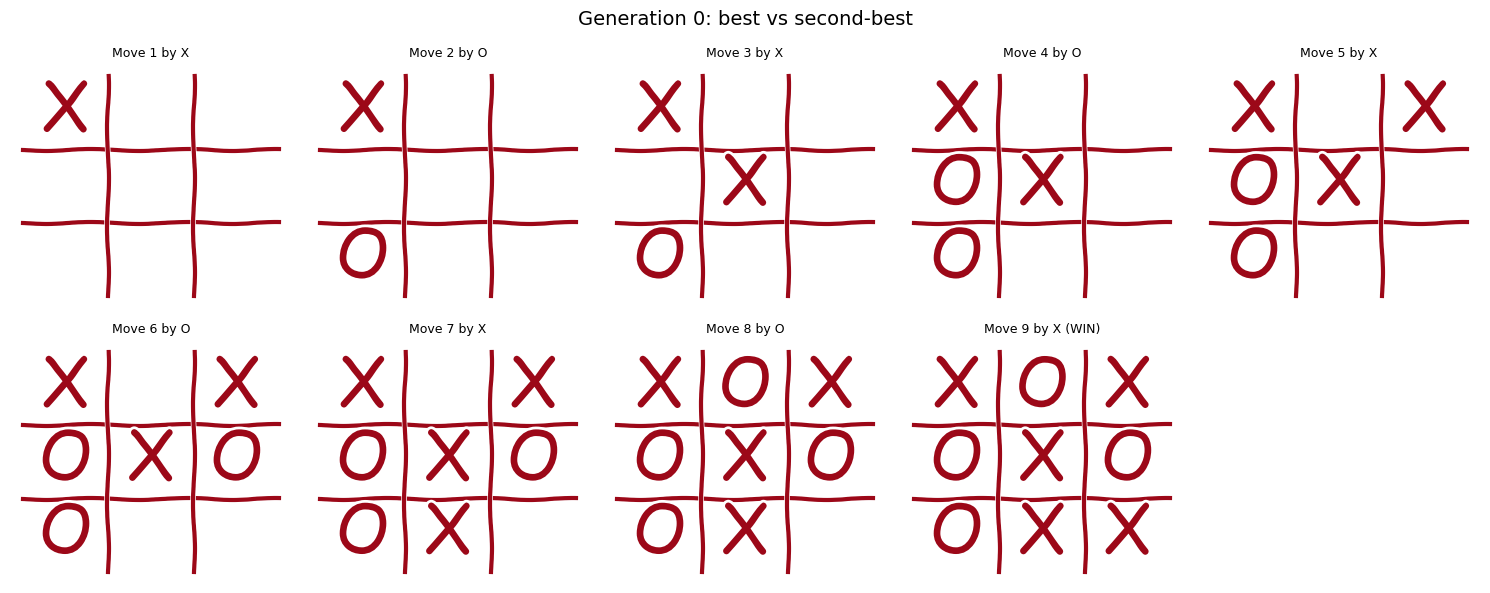



=== Generation 1 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 2 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 3 ===
  Best fitness: 5.1
  Second best fitness: 4.1
=== Generation 4 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 5 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 6 ===
  Best fitness: 5
  Second best fitness: 5
=== Generation 7 ===
  Best fitness: 4.1
  Second best fitness: 4.1
=== Generation 8 ===
  Best fitness: 5
  Second best fitness: 4
=== Generation 9 ===
  Best fitness: 5
  Second best fitness: 5
=== Generation 10 ===
  Best fitness: 5
  Second best fitness: 4.1
=== Generation 11 ===
  Best fitness: 6
  Second best fitness: 4
=== Generation 12 ===
  Best fitness: 5
  Second best fitness: 4.1
=== Generation 13 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 14 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 15 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 16 ==

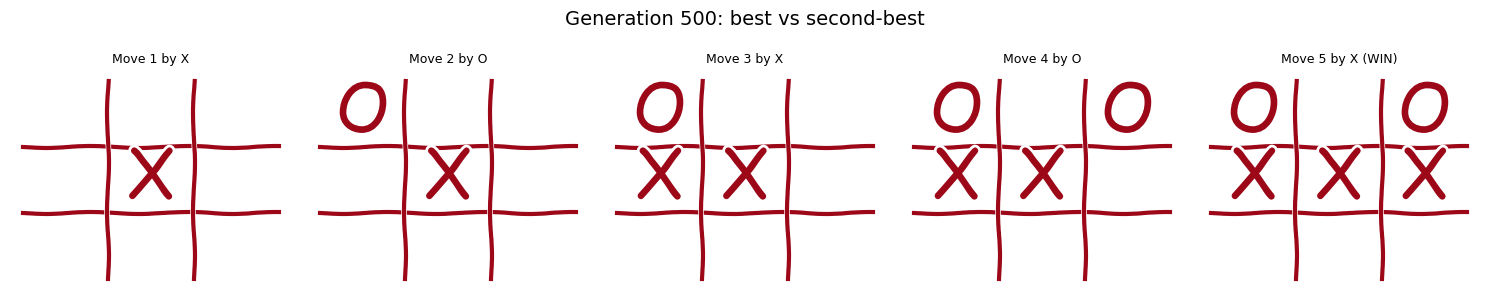



=== Generation 501 ===
  Best fitness: 4.1
  Second best fitness: 4.1
=== Generation 502 ===
  Best fitness: 4.1
  Second best fitness: 3.1
=== Generation 503 ===
  Best fitness: 3.1
  Second best fitness: 3
=== Generation 504 ===
  Best fitness: 3.2
  Second best fitness: 3.1
=== Generation 505 ===
  Best fitness: 3.2
  Second best fitness: 3.1
=== Generation 506 ===
  Best fitness: 3.2
  Second best fitness: 2.2
=== Generation 507 ===
  Best fitness: 4.1
  Second best fitness: 3.2
=== Generation 508 ===
  Best fitness: 4
  Second best fitness: 3.2
=== Generation 509 ===
  Best fitness: 3.3000000000000003
  Second best fitness: 3.1
=== Generation 510 ===
  Best fitness: 4.1
  Second best fitness: 3.1
=== Generation 511 ===
  Best fitness: 4.1
  Second best fitness: 3
=== Generation 512 ===
  Best fitness: 3.1
  Second best fitness: 3.1
=== Generation 513 ===
  Best fitness: 4
  Second best fitness: 3
=== Generation 514 ===
  Best fitness: 4
  Second best fitness: 4
=== Generation 51

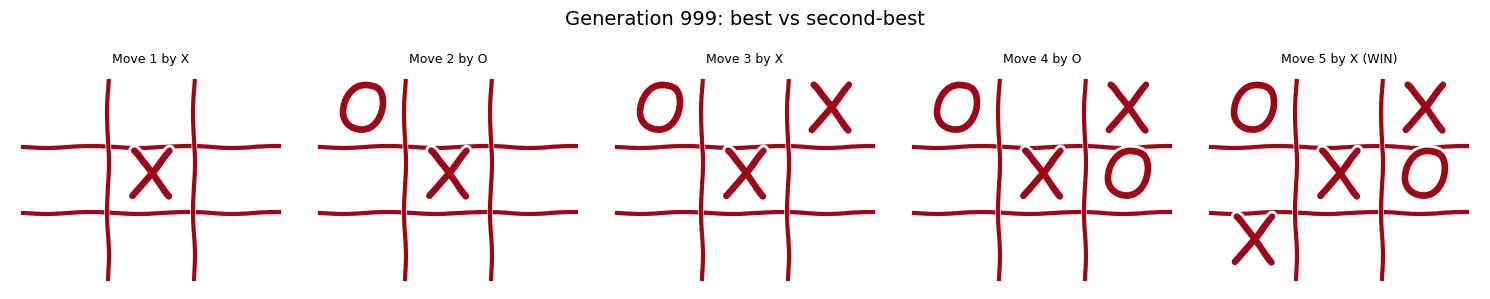

In [59]:
import logging
import math
import matplotlib.pyplot as plt
import random

# Silence font spam from xkcd style
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


# ---------- TRAINING GAME (NO VISUALIZATION) ----------

def simulate_single_game_train(policy1, policy2):
    board = Board(ax=None)

    # Randomly assign who is X and who is O for fairness
    if random.random() < 0.5:
        pX, pO = policy1, policy2
    else:
        pX, pO = policy2, policy1

    current_player = pX
    current_sign = 'X'

    while True:
        move = current_player.place(board, current_sign)
        if not move:
            return None  # should rarely happen

        state = board.place(current_sign, move)

        if state == GameState.WIN:
            current_player.update_fitness(GameState.WIN)
            return current_player
        elif state == GameState.DRAW:
            pX.update_fitness(GameState.DRAW)
            pO.update_fitness(GameState.DRAW)
            return None

        # swap players and signs
        if current_player is pX:
            current_player = pO
            current_sign = 'O'
        else:
            current_player = pX
            current_sign = 'X'


def play_tournament(players, num_games=20):
    # reset fitness
    for p in players:
        p.fitness = 0

    for _ in range(num_games):
        p1, p2 = random.sample(players, 2)
        simulate_single_game_train(p1, p2)

    return players


# ---------- VISUALIZATION HELPERS ----------

def copy_positions(src_positions):
    # deep-copy 3x3 list
    return [row[:] for row in src_positions]


def simulate_single_game_visual(policy1, policy2, label_prefix=""):
    """
    Play a single game between two sign-agnostic policies (Player instances),
    randomly assigning X and O, and visualize the entire game in ONE figure
    as a grid of boards (one per move).

    Fitness is NOT updated here (this is display-only).
    """
    # Logic-only board (no axes)
    logic_board = Board(ax=None)

    # Randomly decide who is X and who is O for this game
    if random.random() < 0.5:
        pX, pO = policy1, policy2
    else:
        pX, pO = policy2, policy1

    current_player = pX
    current_sign = 'X'

    snapshots = []   # list of (positions_copy, sign, state)

    while True:
        # Ask the current policy for a move, given its sign
        move = current_player.place(logic_board, current_sign)
        if not move:
            # Should almost never happen if logic is correct
            print(f"{label_prefix}: No legal moves left – treating as draw.")
            state = GameState.DRAW
            snapshots.append((copy_positions(logic_board.positions),
                              current_sign, state))
            break

        # Apply move to the logical board
        state = logic_board.place(current_sign, move)

        # Save snapshot after this move
        snapshots.append((copy_positions(logic_board.positions),
                          current_sign, state))

        # Stop if game is finished
        if state in (GameState.WIN, GameState.DRAW):
            break

        # Switch player and sign
        if current_player is pX:
            current_player = pO
            current_sign = 'O'
        else:
            current_player = pX
            current_sign = 'X'

    if not snapshots:
        print(f"{label_prefix}: No moves played, nothing to visualize.")
        return

    # ---- Draw all moves in one figure (grid of subplots) ----
    n_moves = len(snapshots)
    ncols = min(n_moves, 5)
    nrows = math.ceil(n_moves / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(3 * ncols, 3 * nrows))

    # Normalize axes to 2D list
    if nrows == 1 and ncols == 1:
        axes_grid = [[axes]]
    elif nrows == 1:
        axes_grid = [axes]
    elif ncols == 1:
        axes_grid = [[ax] for ax in axes]
    else:
        axes_grid = axes

    for idx, (positions, sign, state) in enumerate(snapshots):
        r = idx // ncols
        c = idx % ncols
        ax = axes_grid[r][c]

        vis_board = Board(ax)
        vis_board.positions = positions
        vis_board.draw_board()

        title = f"Move {idx + 1} by {sign}"
        if state == GameState.WIN:
            title += " (WIN)"
        elif state == GameState.DRAW:
            title += " (DRAW)"
        ax.set_title(title, fontsize=9)

    # Turn off any unused subplots
    for idx in range(n_moves, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes_grid[r][c].axis('off')

    fig.suptitle(label_prefix, fontsize=14)
    fig.tight_layout()
    plt.show()
    plt.close(fig)  # avoid accumulating open figures

    # Visual separator between games in text output
    print("\n" + "=" * 70 + "\n")


# ---------- EVOLUTION ----------

def evolve_players(players, retain_top=0.3, mutation_rate=0.1):
    """
    Evolve a population of sign-agnostic Player policies.

    - Sort by fitness (descending)
    - Keep the top `retain_top` fraction as elites
    - Refill the rest of the population by cloning + mutating elites
    """
    # Sort by fitness (best first)
    players = sorted(players, key=lambda p: p.fitness, reverse=True)

    # How many to keep unchanged (elites)
    num_keep = max(2, int(len(players) * retain_top))
    next_gen = players[:num_keep]

    # Fill the rest of the population
    while len(next_gen) < len(players):
        parent = random.choice(players[:num_keep])
        child = Player()                  # new policy (no sign)
        child.brain = parent.brain.copy() # inherit weights
        child.mutate(mutation_rate)       # mutate in-place
        next_gen.append(child)

    return next_gen


# ---------- MAIN TRAINING LOOP ----------

num_generations = 1000
games_per_generation = 200

# visualize early, middle, and last generation
gens_to_visualize = [0, num_generations // 2, num_generations - 1]

# Initialize population of sign-agnostic players
players = [Player() for _ in range(200)]

for generation in range(num_generations):
    print(f"=== Generation {generation} ===")

    # Run training games (no visualization)
    play_tournament(players, num_games=games_per_generation)

    # Sort and get best + second-best
    sorted_players = sorted(players, key=lambda p: p.fitness, reverse=True)
    best, second_best = sorted_players[0], sorted_players[1]

    print(f"  Best fitness: {best.fitness}")
    print(f"  Second best fitness: {second_best.fitness}")

    # Visualize best vs second-best for selected generations
    if generation in gens_to_visualize:
        print(f"\nVisualizing best vs second-best at generation {generation}...\n")

        # Optional: freeze copies so evolution later doesn't affect what we show
        vis_best = Player()
        vis_best.brain = best.brain.copy()

        vis_second = Player()
        vis_second.brain = second_best.brain.copy()

        simulate_single_game_visual(
            vis_best,
            vis_second,
            label_prefix=f"Generation {generation}: best vs second-best"
        )

    # Evolve population for next generation
    players = evolve_players(players, retain_top=0.3, mutation_rate=0.1)


## Deep Learning Showcase

**Hinweis**: Für strukturierte Daten (Tabellen) wie diese sind klassische ML-Modelle (wie Random Forest oder Gradient Boosting) oft **besser, schneller und einfacher** zu trainieren als Deep Learning.
Deep Learning glänzt besonders bei unstrukturierten Daten wie Bildern, Audio oder komplexem Text.

Hier zeigen wir dennoch kurz, wie man ein einfaches neuronales Netz (MLP) mit Keras erstellt.

In [58]:
# Daten skalieren (MinMax oft besser für NN)
scaler_nn = MinMaxScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

# Modell erstellen
mlp_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history_mlp = mlp_model.fit(X_train_nn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluierung
loss, accuracy = mlp_model.evaluate(X_test_nn, y_test)
print(f"MLP Test Genauigkeit: {accuracy:.4f}")

c:\Users\j.ihl\AppData\Local\anaconda3\envs\KI-Trainieren\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9995 - loss: 0.0189 - val_accuracy: 0.9980 - val_loss: 0.0059
Epoch 2/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9998 - loss: 4.2921e-04 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 3/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9999 - loss: 3.1225e-04 - val_accuracy: 0.9984 - val_loss: 0.0039
Epoch 4/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 2.4848e-04 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 5/5
 225/3217 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9998 - loss: 3.9079e-04

KeyboardInterrupt: 